In [69]:
print("Bismillah Hirrahamaa Nirraheem")

Bismillah Hirrahamaa Nirraheem


In [70]:
import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates['mod'] = go.layout.Template(layout=dict(font=dict(family="Fira Code",size=20)))
pio.templates.default = "plotly_dark+mod"
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OrdinalEncoder,OneHotEncoder,RobustScaler
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from miceforest import ImputationKernel
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score,confusion_matrix,roc_auc_score,roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from missingno import matrix
from zipfile import ZipFile
from IPython.display import clear_output

In [71]:
!kaggle competitions download -c spaceship-titanic
!mv spaceship-titanic.zip /home/sohail/Downloads/
clear_output()

In [72]:
with ZipFile(file='/home/sohail/Downloads/spaceship-titanic.zip',mode="r") as file:
    file.extractall('/home/sohail/Downloads/spaceship-titanic-folder')

In [73]:
train = pd.read_csv('/home/sohail/Downloads/spaceship-titanic/train.csv')
test = pd.read_csv('/home/sohail/Downloads/spaceship-titanic/test.csv')
sample = pd.read_csv('/home/sohail/Downloads/spaceship-titanic/sample_submission.csv')

In [74]:
total = train.copy()

# Table
<font size=4>

|SI.No|Name of Column|Description|
|-----|--------------|-----------|
|1|PassengerId|A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.|
|2|HomePlanet|The planet the passenger departed from, typically their planet of permanent residence|
|3|CryoSleep|Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins|
|4|Cabin|The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.|
|5|Destination|The planet the passenger will be debarking to|
|6|Age|The age of the passenger|
|7|VIP|Whether the passenger has paid for special VIP service during the voyage|
|8|RoomService, FoodCourt, ShoppingMall, Spa, VRDeck|Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities|
|9|Name|The first and last names of the passenger|
|10|Transported| Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict|

</font>

# Preprocessing

## Filling Nan's

as you can see there are quite a bit of Null values which need to be filled, we can apply some stratergies as we will see below

In [75]:
def preprocess_1(data:pd.DataFrame):
    df = data.copy()
    df[['CryoSleep','VIP']] = df[['CryoSleep','VIP']].astype(np.float32)
    df[['Group','Within']] = df.PassengerId.str.split('_',expand=True).astype(np.float32)
    df = df[df.columns[-2:].to_list()+df.columns[1:-2].to_list()]
    df[['deck','num','side']] = df.Cabin.str.split('/',expand=True)
    df = df[df.columns[:4].to_list() + df.columns[-3:].to_list() + df.columns[5:-3].to_list()]
    df['num'] = df['num'].astype(np.float32)
    df[['First','Last']] = df.Name.str.split(' ',expand=True)
    df = df[df.columns[:2].to_list() + df.columns[-2:].to_list() + df.columns[2:-2].to_list()]
    df.drop('Name',axis=1,inplace=True)
    return df.infer_objects()

In [76]:
total_train = preprocess_1(train)
total_test = preprocess_1(test)

In [77]:
total_df = pd.concat([total_train,total_test])
y_total = total_df[['Transported']].astype(np.float32).dropna()
total_df.drop('Transported',axis=1,inplace=True)
total_df.reset_index(inplace=True,drop=True)

In [78]:
num_cols = ['Group','Within','num','Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
cat_cols = ['HomePlanet','CryoSleep','deck','side','Destination','VIP']
last_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
all_cats = []
for col in cat_cols:
    all_cats += total_df[col].dropna().unique().tolist()

- Group, Within don't have any null values as they are from PassengerId column<br>
<br>
<font size=8>
Strategy :
</font>

- The strategy is to first fill null values according to the first and last names of the passengers as they are the closest relations for null values
- The First,Last columns also have null values so for the columns with null we will impute the most recurrent in terms of categorical column
- Then Look for the best predictors for single na values and impute those
- The impute the doubly filled columns with clustering/normal imputation


Missing Values

<AxesSubplot:>

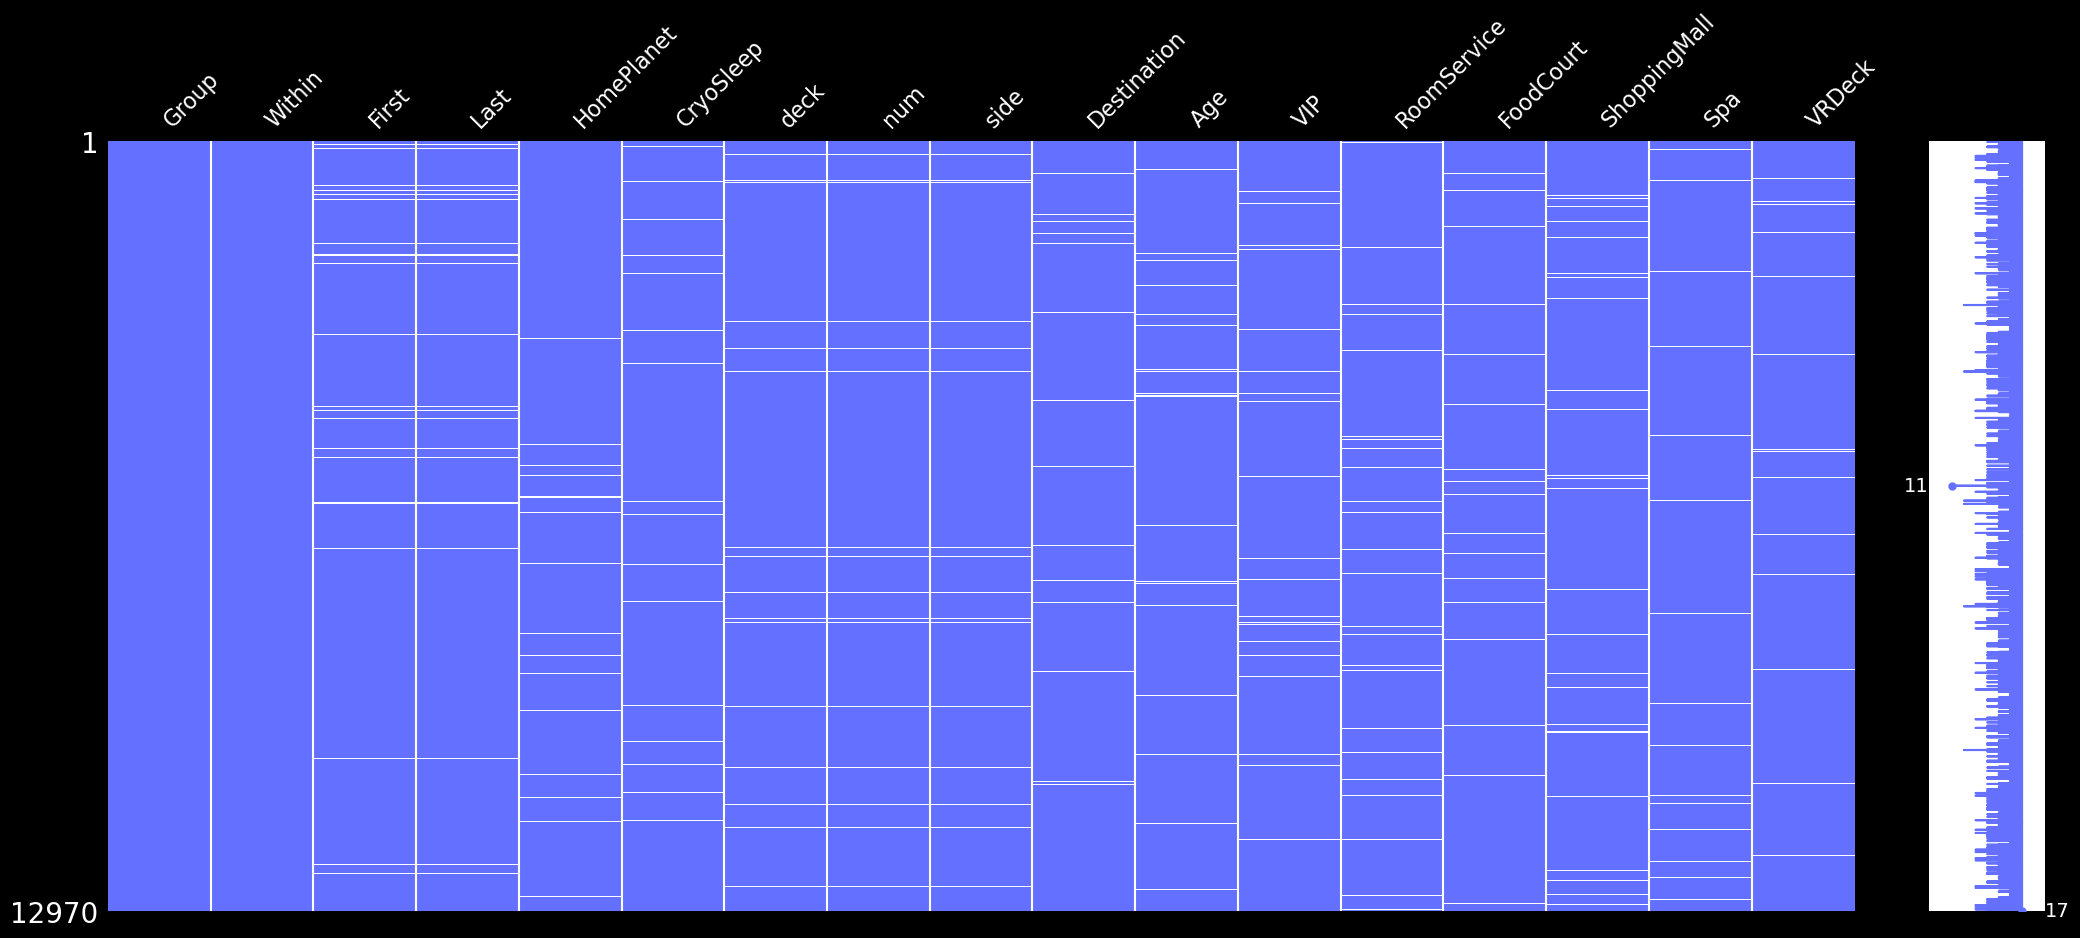

In [79]:
plt.style.use('dark_background')
matrix(total_df,color=(99/250,110/250,1))

In [80]:
total_no_na = total_df.dropna()
total_na = total_df[total_df.isna().any(axis=1)]
print("No NaN shape",total_no_na.shape)
print("any NaN shape",total_na.shape)

No NaN shape (9887, 17)
any NaN shape (3083, 17)


In [81]:
temp_df = pd.get_dummies(total_no_na,columns=['HomePlanet','deck','side','Destination'],prefix="",prefix_sep="",dtype=np.float32)
temp_df = temp_df.loc[:,temp_df.columns.difference(['First','Last'])].corr(method='spearman')
np.fill_diagonal(temp_df.to_numpy(),0)
px.imshow(temp_df,height=1000,width=1800).update_xaxes(tickangle=30)

filling the values with same First Name

before filling 

In [82]:
print("before filling :")
print("no of single vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 1)].shape[0])
print("no of double vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 2)].shape[0])
print("no of triple vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 3)].shape[0])

before filling :
no of single vacant rows : 2274
no of double vacant rows : 441
no of triple vacant rows : 303


In [83]:
for ind in total_na.index:
    col = total_na.columns[total_na.loc[ind].isna()]
    temp_df = total_no_na.query(f"Group == {total_na.loc[ind,'Group']} and Last == '{total_na.loc[ind,'Last']}'")
    if temp_df.shape[0] != 0:
        total_df.loc[ind,col] = temp_df.loc[temp_df.index[0],col]

In [84]:
print("after filling :")
print("no of single vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 1)].shape[0])
print("no of double vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 2)].shape[0])
print("no of triple vacant rows :",total_df.loc[(total_df.isna().sum(axis=1) == 3)].shape[0])

after filling :
no of single vacant rows : 1466
no of double vacant rows : 364
no of triple vacant rows : 214


In [85]:
total_no_na = total_df.dropna()
total_na = total_df[total_df.isna().any(axis=1)]
print("No NaN shape",total_no_na.shape)
print("any NaN shape",total_na.shape)

No NaN shape (10880, 17)
any NaN shape (2090, 17)


In [86]:
temp_df = pd.get_dummies(total_no_na,columns=['HomePlanet','deck','side','Destination'],prefix="",prefix_sep="",dtype=np.float32)
temp_df = temp_df.drop(['First','Last'],axis=1).corr(method='spearman')
np.fill_diagonal(temp_df.to_numpy(),0)
px.imshow(temp_df,height=1000,width=1800).update_xaxes(tickangle=30)

In [87]:
temp_df = total_df.drop(['First','Last'],axis=1)
temp_df = pd.get_dummies(temp_df,columns=['HomePlanet','side','deck','Destination'],prefix_sep="",prefix="",dtype=np.float32)
kds = ImputationKernel(temp_df,random_state=55,save_all_iterations=True,datasets=4)
kds.mice(10,n_estimators=100,max_depth=6)
new_data = kds.complete_data()

In [88]:
stan = StandardScaler()
stan.set_output(transform='pandas')
new_data = stan.fit_transform(new_data[num_cols])
train_set = new_data.loc[:8692].copy()
test_set = new_data.loc[8693:].copy()

In [89]:
y_arr = y_total.to_numpy().ravel()
X_train,X_test,y_train,y_test = train_test_split(train_set.to_numpy(),y_arr,stratify=y_arr)
grad = GradientBoostingClassifier(n_estimators=100,max_depth=6)
grad.fit(X_train,y_train)
grad.score(X_test,y_test)

/home/sohail/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



0.7870285188592456

In [90]:
class TotalTransform(BaseEstimator,TransformerMixin):

    def __init__(self,train=True):
        self.train = train

    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        pass

# Rough Work

In [91]:
# check for corr() coefficient
# arr1 = np.random.randint(20,40,30)
# arr2 = np.random.randint(1,20,30)
# temp_df = pd.DataFrame(np.hstack([arr1,arr2]),columns=["num"])
# temp_df.loc[:30,'choice'] = 0
# temp_df.loc[30:,'choice'] = 1
# temp_df.corr()
# check for same deck,num,side in total_na
# num = 2
# total_no_na.query(f"Last == '{total_na.query('deck != deck').Last.iloc[num]}' and Group == {total_na.query('deck != deck').Group.iloc[num]}")